<a href="https://colab.research.google.com/github/ArtemNechaev/AI_bot/blob/main/Telgrambot_NLPmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install transformers

In [ ]:
!pip install datasets transformers sentencepiece
!pip install tensorboard
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 29.1 MB/s 
     |████████████████████████████████| 4.4 MB 60.3 MB/s 
     |████████████████████████████████| 1.2 MB 50.6 MB/s 
     |████████████████████████████████| 140 kB 60.1 MB/s 
     |████████████████████████████████| 212 kB 68.5 MB/s 
     |████████████████████████████████| 1.1 MB 55.8 MB/s 
     |████████████████████████████████| 101 kB 11.8 MB/s 
     |████████████████████████████████| 596 kB 75.7 MB/s 
     |████████████████████████████████| 127 kB 62.7 MB/s 
     |████████████████████████████████| 6.6 MB 70.1 MB/s 
     |████████████████████████████████| 271 kB 56.2 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 144 kB 7.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib

# Imports and login

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, T5Tokenizer, pipeline
from huggingface_hub import notebook_login
import torch
from google.colab import drive
drive.mount('/content/drive')

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


#Prune vocab

In [ ]:
model_checkpoint='google/mt5-base'
new_model_checkpint = 'artemnech/enrut5-base'

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast =False)

Downloading:   0%|          | 0.00/2.17G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [ ]:
import re
regex_filter = re.compile(r'[а-яА-ЯёЁa-zA-Z0-9!@#$%^&*()\"№;%:?*\|\[\]{}▁,<>=+-`~]')
special_tokens = tokenizer.special_tokens_map.values()
keep = [ 
          index  for word, index in tokenizer.get_vocab().items() 
          if len(regex_filter.findall(word)) > 0.99*len(word) or index < 260 or index > tokenizer.vocab_size-101
        ]

keep = sorted(keep)
keep = keep[:45000] + keep[-100:]

In [ ]:
from sentencepiece import sentencepiece_model_pb2 as spmp
smp = tokenizer.sp_model.serialized_model_proto()
m = spmp.ModelProto()
m.ParseFromString(smp)
print('the loaded model has pieces:', len(m.pieces))
new_pieces = [m.pieces[idx] for idx in keep]
print('the new pieces:', len(new_pieces))
# replace the content of the first 30K pieces
for i, p in enumerate(new_pieces):
    m.pieces[i].piece = p.piece
    m.pieces[i].score = p.score
    m.pieces[i].type = p.type
# drop the remaining pieces
n = len(new_pieces)
for i in range(len(m.pieces) - n):
    m.pieces.pop()


print(len(m.pieces))
with open('new_sp.model', 'wb') as f:
    f.write(m.SerializeToString())

the loaded model has pieces: 250100
the new pieces: 45100
45100


In [ ]:
embed=torch.nn.Embedding(len(keep), model.shared.embedding_dim,)
embed.load_state_dict({'weight': model.shared.weight[keep]})

model.shared = embed
model.encoder.embed_tokens = embed
model.decoder.embed_tokens = embed

In [ ]:
lm_head = torch.nn.Linear(model.shared.embedding_dim, len(keep), bias = False)
lm_head.load_state_dict({'weight': model.lm_head.weight[keep]})
model.lm_head = lm_head

model.config.__dict__['vocab_size'] = 45100
model.config.__dict__['_name_or_path'] = new_model_checkpint


In [ ]:
new_tokenizer = T5Tokenizer('new_sp.model', extra_ids=0)
#new_tokenizer = AutoTokenizer.from_pretrained('artemnech/en-ruT5')

In [ ]:
print(new_tokenizer.convert_ids_to_tokens(new_tokenizer('Привет, как дела?').input_ids))
new_tokenizer.decode(new_tokenizer('Привет, как дела?').input_ids, skip_special_tokens=True)

['▁При', 'вет', ',', '▁как', '▁дела', '?', '</s>']


'Привет, как дела?'

In [ ]:
print(tokenizer.convert_ids_to_tokens(tokenizer('Привет, как дела?').input_ids))
tokenizer.decode(tokenizer('Привет, как дела?').input_ids, skip_special_tokens=True)


['▁При', 'вет', ',', '▁как', '▁дела', '?', '</s>']


'Привет, как дела?'

In [ ]:
tokenizer = new_tokenizer

# Data proccessing

In [ ]:
from datasets import load_dataset, concatenate_datasets
import random

dataset = load_dataset('daily_dialog')
translate_dataset = load_dataset('wmt16', 'ru-en')


Using custom data configuration default


Generating train split:   0%|          | 0/11118 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset daily_dialog downloaded and prepared to /root/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split:   0%|          | 0/1516162 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2818 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2998 [00:00<?, ? examples/s]

Dataset wmt16 downloaded and prepared to /root/.cache/huggingface/datasets/wmt16/ru-en/1.0.0/9e0038fe4cc117bd474d2774032cc133e355146ed0a47021b2040ca9db4645c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
prefix = 'dialog: '
users = ['user1>>: ', 'user2>>: ']
greetings = [
              ['Hello', 'Hi', 'How are you?', "I can't complain"],
              ["Hey, What’s up?", "Hi! I’m great"],
              ["Good afternoon", "Hello", "How are you doing?", "I'am tired"]
             ]
greetings = greetings*1000

def preprocess_function(examples):
  inputs, targets = [], []
  for example in examples['dialog']:
    if greetings and random.random() > 0.7:
      example = greetings[-1] + example
      greetings.pop()
    example = [u+e for e, u in zip(example, users*(1 + len(example)//2))]
    for i in range(len(example)-1):
      inputs.append(prefix + ' '.join(example[:i+1]))
      targets.append(example[i+1])

  model_inputs = tokenizer(inputs, max_length=300, truncation=True)

  with tokenizer.as_target_tokenizer():
      labels = tokenizer(targets, max_length=128, truncation=True)

  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset.column_names['train'])
tokenizer.decode(dataset['train'][5]['input_ids'])

Parameter 'function'=<function preprocess_function at 0x7f11ea657170> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

"dialog: user1>>: Say, Jim, how about going for a few beers after dinner? user2>>: You know that is tempting but is really not good for our fitness. user1>>: What do you mean? It will help us to relax. user2>>: Do you really think so? I don't. It will just make us fat and act silly. Remember last time? user1>>: I guess you are right.But what shall we do? I don't feel like sitting at home. user2>>: I suggest a walk over to the gym where we can play singsong and meet some of our friends.</s>"

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 86052
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7069
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6740
    })
})

In [ ]:
source_lang = "en"
target_lang = "ru"
prefix = "translate"

def preprocess_function(examples):
  inputs, targets = [], []
  for example in examples["translation"]:
    inputs.append(prefix + f' {source_lang} to {target_lang}: ' + example[source_lang])
    inputs.append(prefix + f' {target_lang} to {source_lang}: ' + example[target_lang])
    targets.append(example[target_lang])
    targets.append(example[source_lang])

  model_inputs = tokenizer(inputs, max_length=128, truncation=True)

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(targets, max_length=128, truncation=True)

  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

translate_dataset = translate_dataset.map(preprocess_function, batched=True, remove_columns=translate_dataset.column_names['train'])

tokenizer.decode(translate_dataset['train'][101]['input_ids']), tokenizer.decode(translate_dataset['train'][101]['labels'])

  0%|          | 0/1517 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

('translate ru to en: Я неделю восстанавливал старые семейные фото начала века каждую фотографию, а здесь за 15 минут выполнил всю основную обработку!</s>',
 "I've tried so many times to cover the tattoos and couldn't. I downloaded a trial of Retoucher to see how it would work.</s>")

In [ ]:
for label in ['train', 'validation', 'test' ]:
   dataset[label] = concatenate_datasets([dataset[label], translate_dataset[label]])

dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3118376
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12705
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12736
    })
})

In [ ]:
from torch.utils.data import Sampler
import random
class TrainSampler(Sampler):
    def __init__(self, len_dialog_dataset, len_dataset,):
        self.len_dialog_dataset = len_dialog_dataset
        self.len_dataset = len_dataset

    def __iter__(self):
        indices = torch.randperm(self.len_dialog_dataset).tolist() + torch.randint(self.len_dialog_dataset, self.len_dataset,
                                                                            (self.len_dialog_dataset,)).tolist()
        random.shuffle(indices)
        yield from indices
    def __len__(self):
      return self.len_dialog_dataset * 2

train_sampler = TrainSampler(len(dataset['train'])-len(translate_dataset['train']), len(dataset['train']) )

# Metrics

In [ ]:
from torchtext.data.metrics import bleu_score
def bleu(preds, targets ):
  
  ref= [[_.split()] for _ in targets]
  pred = [_.split() for _ in preds]
  return bleu_score(pred, ref)


# Trainer

In [ ]:
from typing import Dict
from transformers import DataCollatorForSeq2Seq
from torch.utils.data import RandomSampler
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output
import matplotlib.pyplot as plt
import random
import datetime
import numpy as np
import os


class Trainer():
  def __init__(self, train_dataset, val_dataset, model, tokenizer, 
               batch_size, num_epoch, lr=5e-5, weight_decay=0, metrics = [], 
               optimizer = None, scheduler =None, eval_freq = 500, saving_path = '/', model_name='model', sampler = None):
    
    self.train_dataset = train_dataset
    self.val_dataset = val_dataset
    self.model = model
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.device = model.device
    self.num_epoch = num_epoch
    self.metrics = metrics
    self.eval_freq = eval_freq
    self.saving_path = saving_path
    self.model_name = model_name + '.pt'

    if optimizer is not None:
       self.optimizer = optimizer(self.model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
       self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=weight_decay)

    self.scheduler = scheduler
    self.data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

    if sampler is None:
      self.sampler = RandomSampler(self.train_dataset)
    else:
      self.sampler = sampler


  def data2device(self, data: Dict):
    return {k: v.to(self.device) for k, v in data.items()}

  def train(self):
    best_val_loss = float('inf')
    dt =datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    writer = SummaryWriter(log_dir=os.path.join(self.saving_path, dt))
    

    train_dataloader = torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, 
                                                   collate_fn=self.data_collator, 
                                                   sampler = self.sampler)
    val_dataloader = torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, collate_fn=self.data_collator)

    #prepare examples to show it on tensorboard text
    random_eval_examples = random.sample(range(len(self.val_dataset)), 30)
    
    input_examples = self.tokenizer.batch_decode(self.val_dataset[random_eval_examples]['input_ids'], skip_special_tokens=True)
    target_examples = self.val_dataset[random_eval_examples]['labels']
    target_examples = np.where(target_examples != -100, target_examples, self.tokenizer.pad_token_id)
    target_examples = self.tokenizer.batch_decode(target_examples, skip_special_tokens=True)

    for id, input, target in zip(random_eval_examples, input_examples, target_examples):
      input = "  \n".join(input.split('user'))
      writer.add_text(f'example {id}/input', input +'  \n'+ target , 0)

    

    for epoch in range(self.num_epoch):
      train_loss_set = []
      train_loss = 0

      val_loss_set = []
      x_val_set = []

      for step, batch in enumerate(train_dataloader):

        # Training
        self.model.train()
        batch = self.data2device(batch)
        
        self.optimizer.zero_grad()
        outputs = self.model(**batch)
        train_loss_set.append(outputs.loss.item())  
        outputs.loss.backward()
        self.optimizer.step()
        train_loss += outputs.loss.item()
        
        #Evaluation
        if step != 0 and (step % self.eval_freq == 0 or step == len(train_dataloader)-1):
            val_loss = 0
            preds = []
            targets = []
            for val_batch in val_dataloader:
                val_batch = self.data2device(val_batch)
                self.model.eval()
                with torch.no_grad():
                    outputs =  self.model(**val_batch)
                    val_loss += outputs.loss.item()
                    outputs = self.model.generate(input_ids=val_batch["input_ids"],
                                    attention_mask=val_batch["attention_mask"], 
                                    num_beams=1, max_length = 50,)
                    
                    preds += self.tokenizer.batch_decode(outputs, skip_special_tokens=True)
                    targets += self.tokenizer.batch_decode(val_batch['decoder_input_ids'], skip_special_tokens=True)

            val_loss = val_loss/len(val_dataloader)
            val_loss_set.append(val_loss)
            x_val_set.append(step)

            #savemodel
            if val_loss < best_val_loss:
              best_val_loss = val_loss
              torch.save(self.model.state_dict(), os.path.join(self.saving_path, self.model_name))

            #log to tensorboard
            for name, func in self.metrics:
              value = func(preds, targets)
              writer.add_scalar(name, value, step + len(train_dataloader)*epoch)

            writer.add_scalar("Loss/val", val_loss, step + len(train_dataloader)*epoch)
            writer.add_scalar("Loss/train", train_loss/(step + 1), step + len(train_dataloader)*epoch)
            
            for id, text in zip(random_eval_examples, np.array(preds)[random_eval_examples]):
              writer.add_text(f'example {id}/preds',text, step + len(train_dataloader)*epoch)
            
            
        
        if step % 15 == 0:
          clear_output(True)
          plt.grid()
          plt.plot(train_loss_set)
          plt.plot(x_val_set,val_loss_set)
          plt.title("Training/Val loss")
          plt.xlabel("Batch")
          plt.ylabel("Loss")
          plt.show()

    if self.scheduler is not None:
      self.scheduler.step(val_loss)

    print("Train Loss: {0:.5f}".format(train_loss / len(train_dataloader)))
    print("Validation Loss: {0:.5f}".format(val_loss))
    writer.close()

#Traning

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
  print(torch.cuda.get_device_name())

Tesla T4


In [ ]:
model.load_state_dict(torch.load('drive/MyDrive/ML/enrut5-base/model.pt', map_location = device))
model = model.to(device)
trainer = Trainer(
    dataset['train'],
    dataset['validation'],
    model,
    tokenizer,
    batch_size = 7,
    num_epoch = 1,
    lr=5e-5,
    metrics=[('bleu', bleu)],
    eval_freq = 5000,
    weight_decay=0.000001,
    sampler = train_sampler,
    saving_path = 'drive/MyDrive/ML/enrut5-base',
)

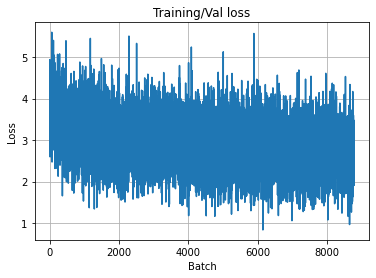

In [ ]:
trainer.train()

In [ ]:
model.load_state_dict(torch.load('drive/MyDrive/ML/enrut5-base/model.pt', map_location = device))

<All keys matched successfully>

In [ ]:
model.push_to_hub('enrut5-base')
tokenizer.push_to_hub('enrut5-base')

In [ ]:
!ngrok authtoken 2B6KxiUONU9ykyS9xe6M0b5HSNk_3h1exvb9eomrDcc7Cp9eh
!nohup ngrok http -log=stdout 6006 > /dev/null &

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
nohup: redirecting stderr to stdout


In [ ]:
!tensorboard --logdir=drive/MyDrive/ML/enrut5-base/runs


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL+C to quit)


In [ ]:
!tensorboard dev upload --logdir drive/MyDrive/runs \
--name "My en-ru T5 model" \
--description "Finetuning mt5-base model on wmt16 an daily dialogs datasets"

# Evaluation


In [ ]:
model = model.to(device)
#model = AutoModelForSeq2SeqLM.from_pretrained('artemnech/enrut5-base')
#tokenizer = AutoTokenizer.from_pretrained('artemnech/enrut5-base')

def generate(text, **kwargs):
    inputs = tokenizer(text, return_tensors='pt').to(device)
    with torch.no_grad():
        model.eval()
        hypotheses = model.generate(**inputs,  **kwargs)
    return tokenizer.decode(hypotheses[0], skip_special_tokens=True)



In [ ]:
for i in range(30):
  input = tokenizer.decode(dataset['test'][i+300]['input_ids'])
  target = tokenizer.decode(dataset['test'][i+300]['labels'])
  input = "\n".join(input.split('user'))
  print(input,'\n\n', target, '\n')
  print(generate(input ,do_sample=True, num_beams=5, max_length =30), '\n' )
  print('________________')

In [ ]:
for i in range(7500, 7530):
  input = tokenizer.decode(dataset['test'][i]['input_ids'])
  target = tokenizer.decode(dataset['test'][i]['labels'])
  input = "\n".join(input.split('user'))
  print(input,'\n\n', target, '\n')
  print(generate(input ,do_sample=False, num_beams=2), '\n' )
  print('________________')

In [ ]:
generate('dialog: user2>>: I ate porridge today', num_beams=1, do_sample=True)

'user2>>: No pound porridge...'

In [ ]:
generate('translate ru to en: Вот и все', num_beams=4,)

'Вот и все'